In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Warning CUDA not Found. Using CPU")

# Hyper-parameters
num_epochs = 8
learning_rate = 1e-3

In [3]:
#Data
print("> Setup dataset")
transform = transforms.Compose([transforms.ToTensor()])  # Only ToTensor, which normalizes to [0,1]

trainset = torchvision.datasets.MNIST(root='/mnt/d/uqwdai1/data/rdm_backed/pytorch/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True) #num_workers=6

testset = torchvision.datasets.MNIST(root='/mnt/d/uqwdai1/data/rdm_backed/pytorch/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False) #num_workers=6

> Setup dataset
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:12<00:00, 766kB/s] 


Extracting /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw\train-images-idx3-ubyte.gz to /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 121kB/s]


Extracting /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw\train-labels-idx1-ubyte.gz to /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 801kB/s] 


Extracting /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw\t10k-images-idx3-ubyte.gz to /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.47MB/s]

Extracting /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw\t10k-labels-idx1-ubyte.gz to /mnt/d/uqwdai1/data/rdm_backed/pytorch/MNIST\raw



In [4]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder (same as before but outputs mean and log_var)
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # 7x7 -> 4x4

            nn.Flatten(),
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),  # Reshape to (batch, 128, 4, 4)

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False),  # 16x16 -> 28x28
            nn.Sigmoid()  # Output in [0, 1] for image reconstruction
        )

    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu  # Use mean for inference. Using mu (mean) rather than sampling from the full distribution because:
                        # It provides deterministic, reproducible results
                        # The mean represents the "most likely" latent representation
                        # It avoids noise that could make interpolation less smooth

    def decode(self, z):
        """Decode latent variable to reconstruction"""
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    beta: weight for KL divergence (beta-VAE)
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

Training VAE...
VAE Epoch [1/10], Loss: 158.3914, BCE: 136.3953, KLD: 21.9961


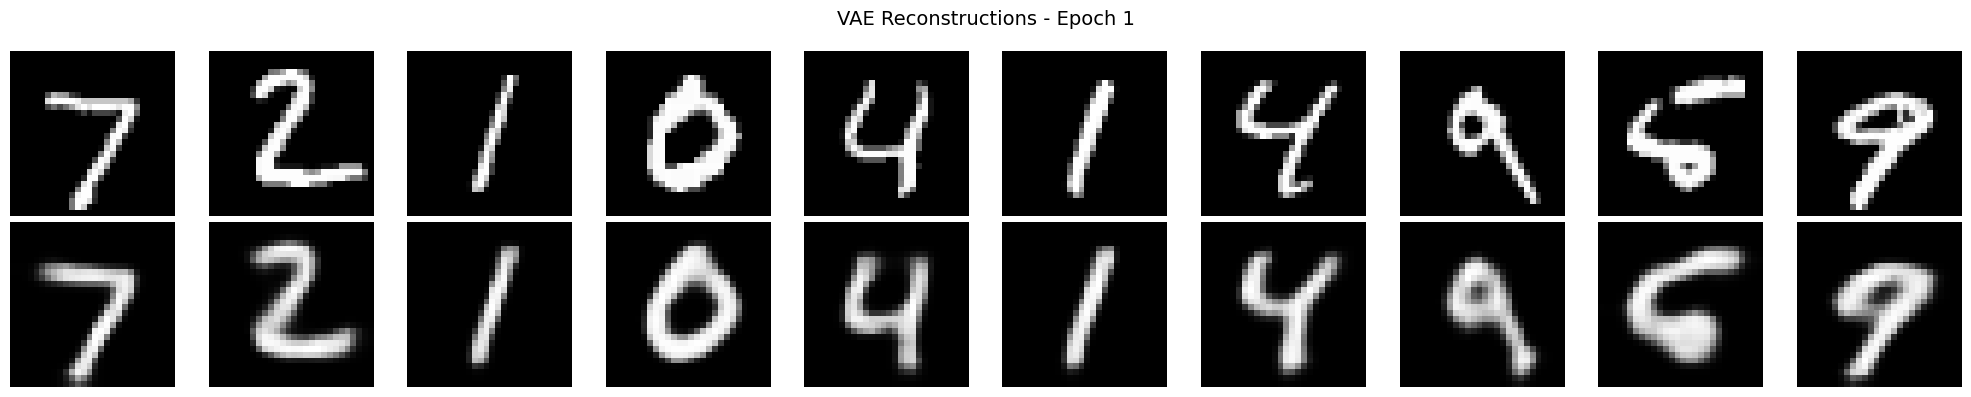

VAE Epoch [2/10], Loss: 123.9280, BCE: 99.3269, KLD: 24.6011


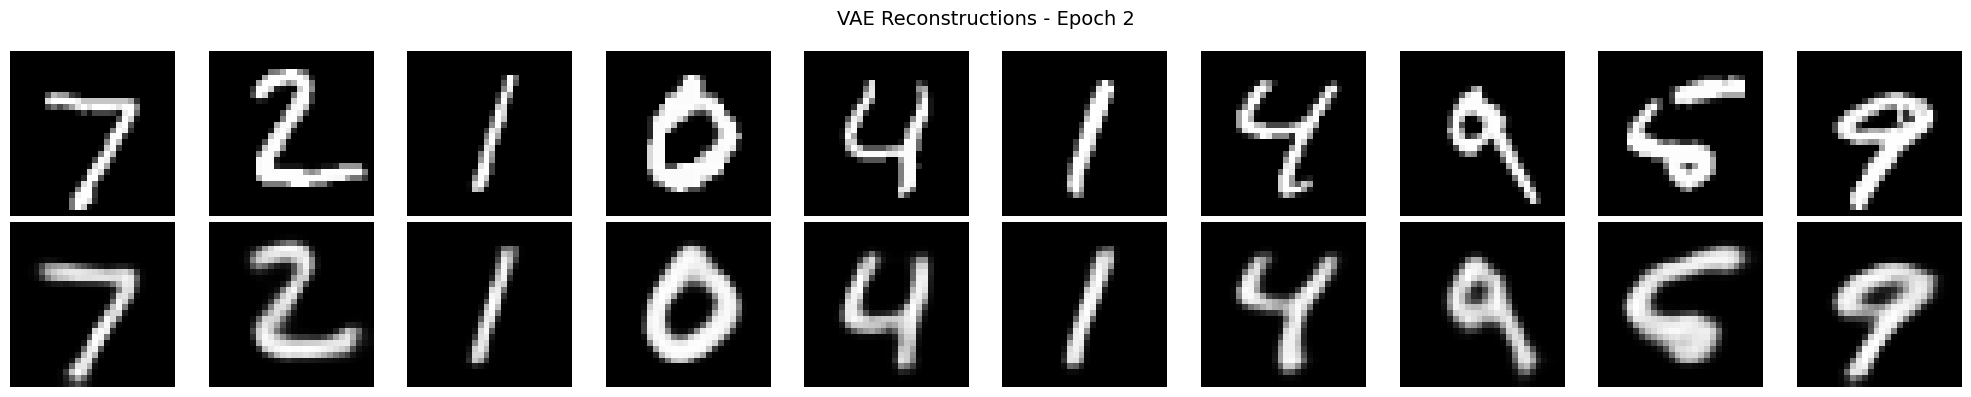

VAE Epoch [3/10], Loss: 117.4455, BCE: 92.6460, KLD: 24.7995


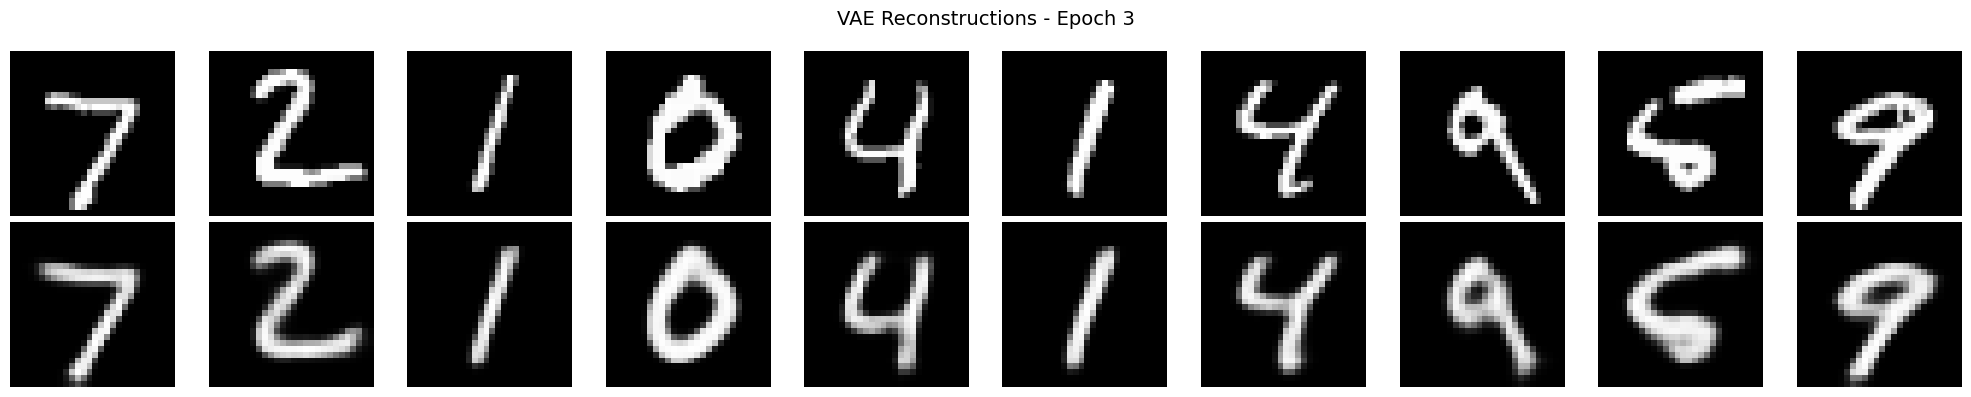

VAE Epoch [4/10], Loss: 114.4516, BCE: 89.5904, KLD: 24.8612


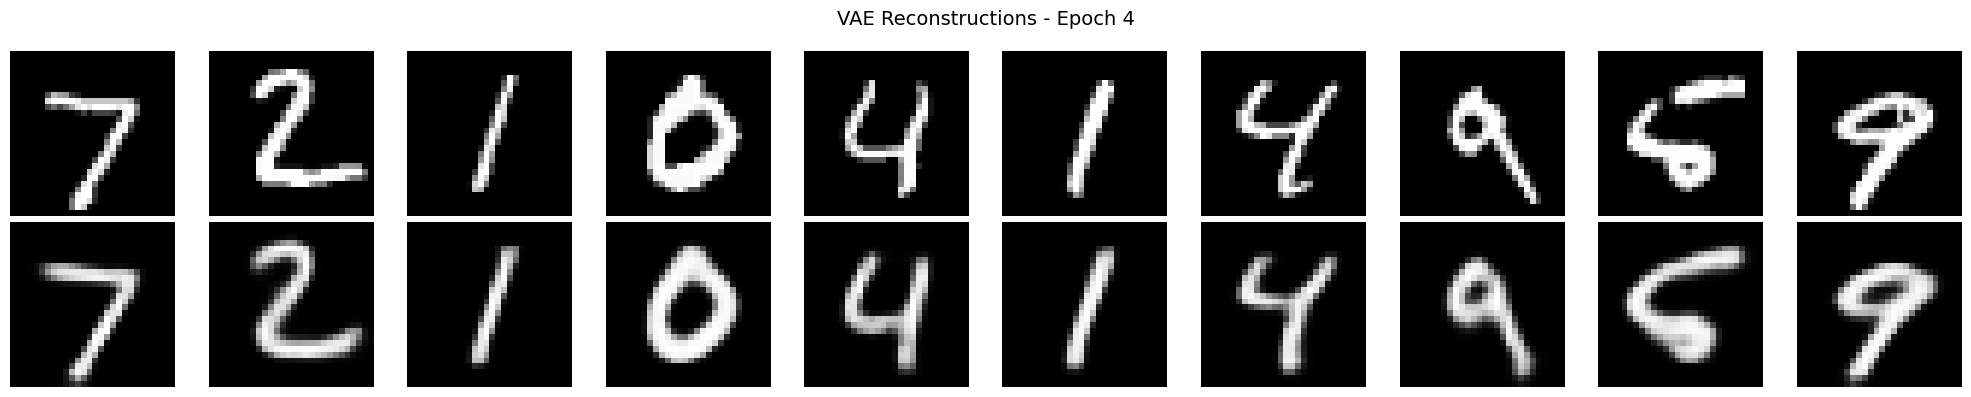

VAE Epoch [5/10], Loss: 112.6773, BCE: 87.7316, KLD: 24.9457


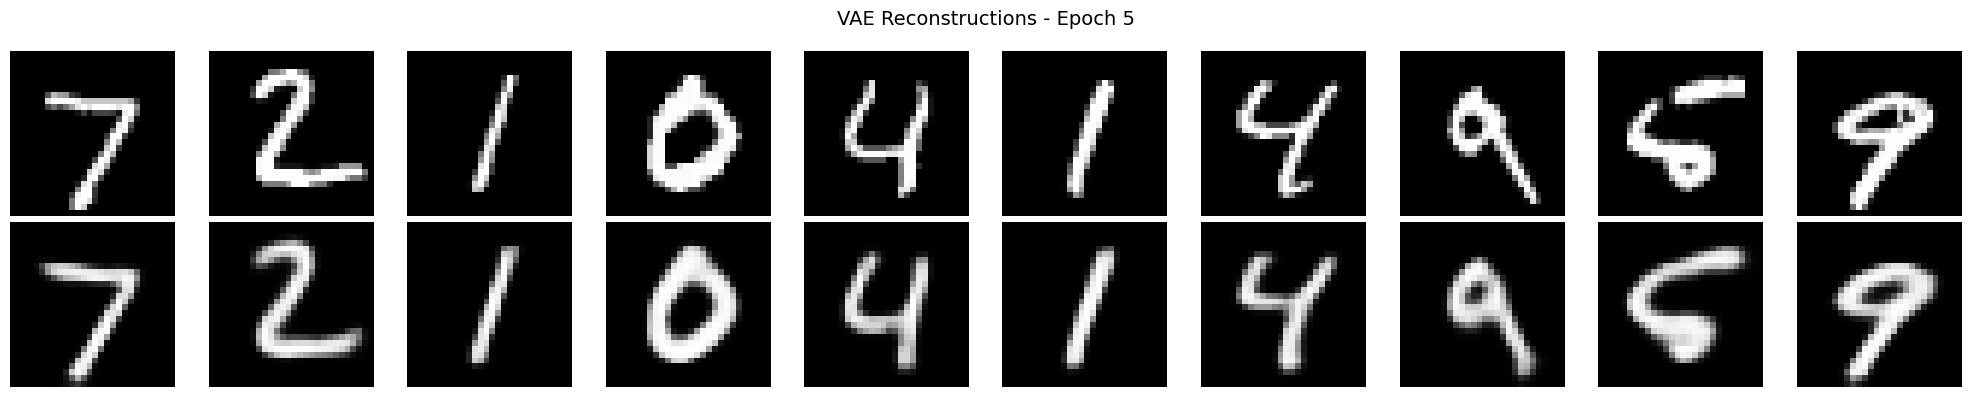

VAE Epoch [6/10], Loss: 111.3384, BCE: 86.3869, KLD: 24.9515


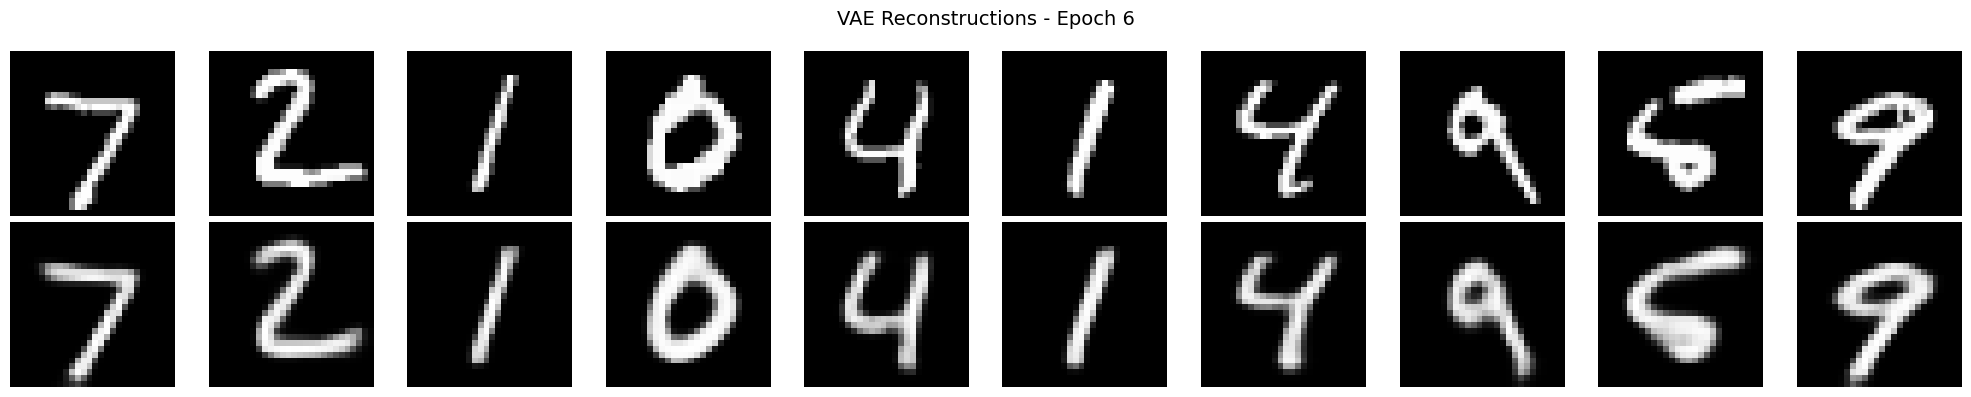

VAE Epoch [7/10], Loss: 110.3174, BCE: 85.3351, KLD: 24.9823


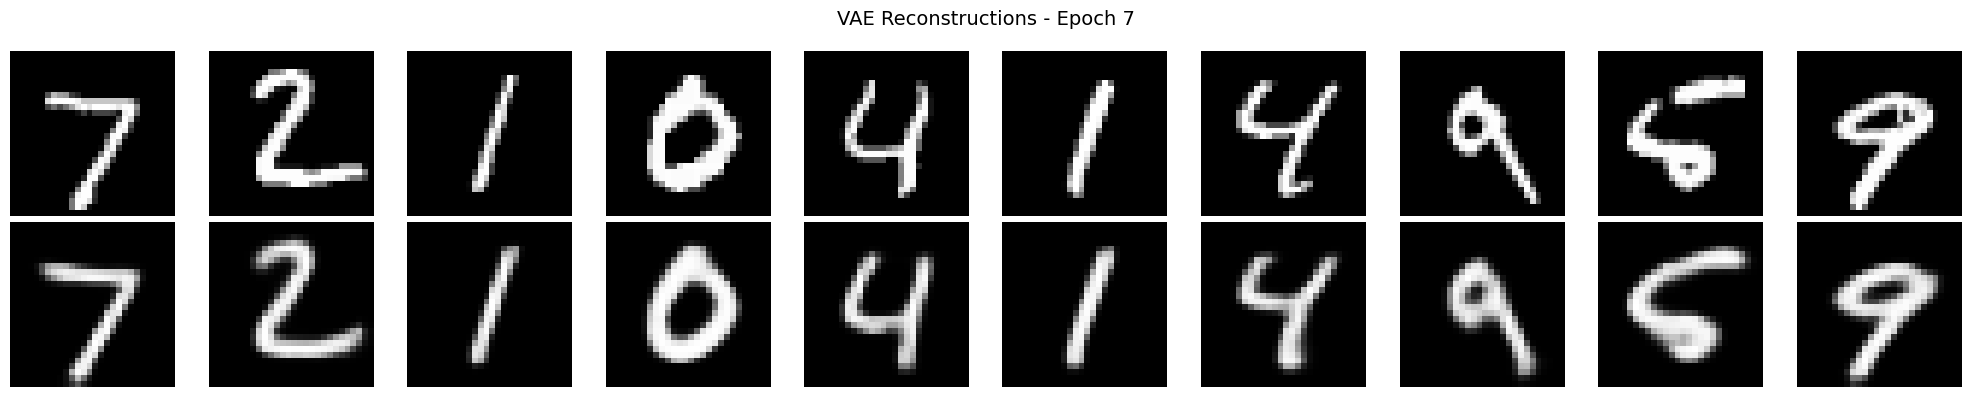

VAE Epoch [8/10], Loss: 109.6300, BCE: 84.6343, KLD: 24.9957


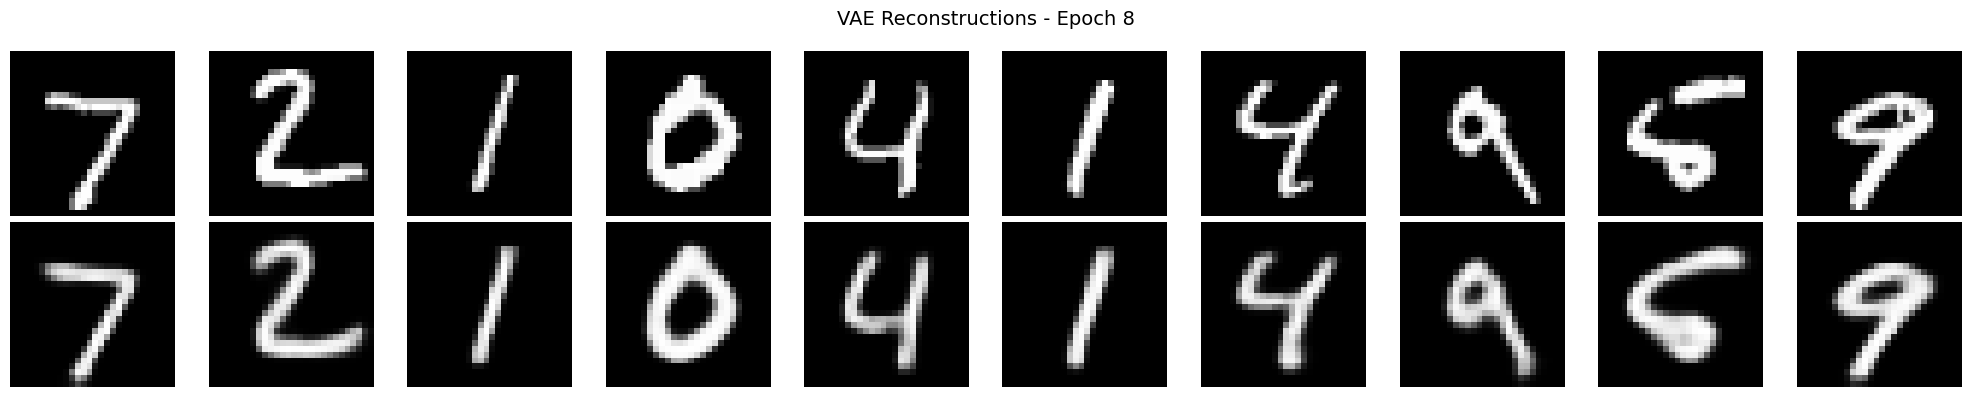

VAE Epoch [9/10], Loss: 108.9820, BCE: 84.0185, KLD: 24.9635


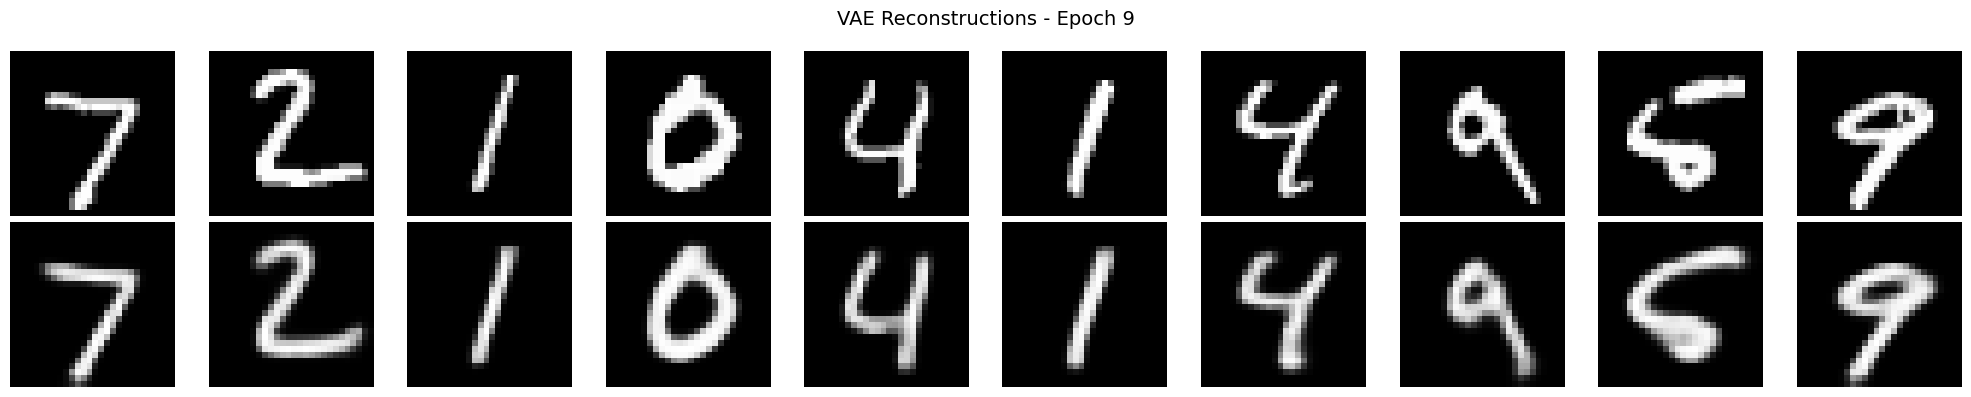

VAE Epoch [10/10], Loss: 108.5081, BCE: 83.5961, KLD: 24.9120


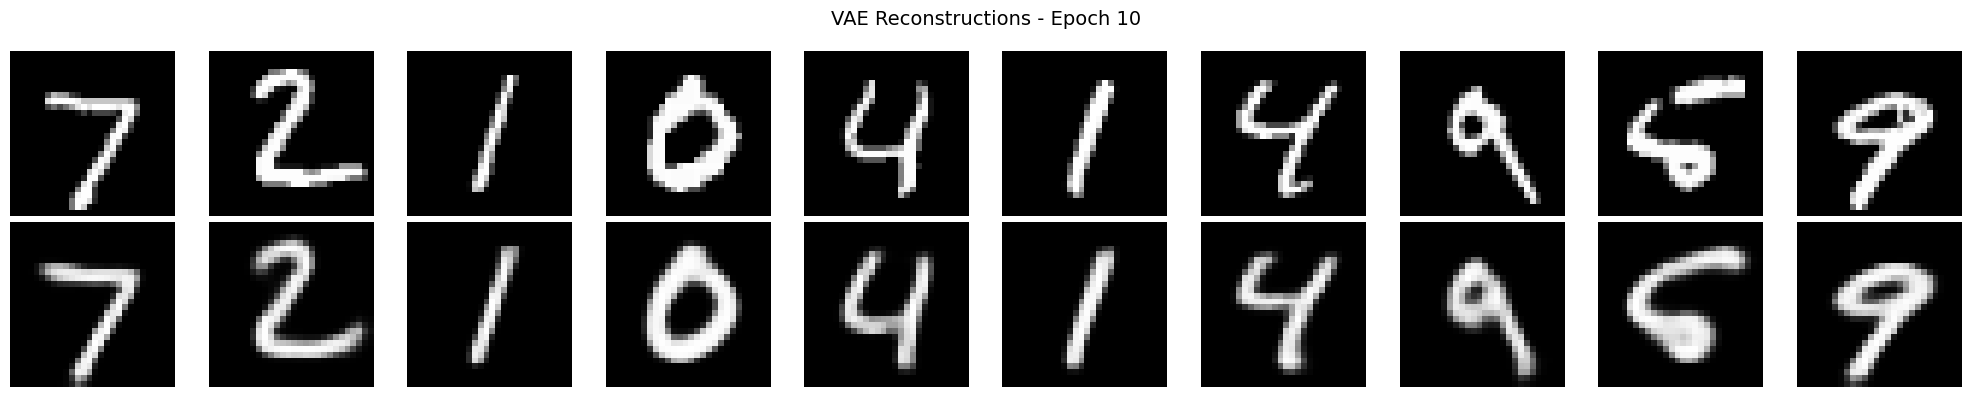

In [5]:
import matplotlib.pyplot as plt
# Train the VAE
vae = CNNVAE(latent_dim=32).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
num_vae_epochs = 10
beta = 1.0  # Beta parameter for beta-VAE (1.0 = standard VAE)

print("Training VAE...")
for epoch in range(num_vae_epochs):
    vae.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = vae(images)

        # Calculate loss
        loss, bce, kld = vae_loss_function(recon_images, images, mu, logvar, beta)

        # Backward pass
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    print(f'VAE Epoch [{epoch+1}/{num_vae_epochs}], Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')

    # Visualize reconstructions every few epochs
    if (epoch + 1) % 1 == 0 or epoch == 0:
        vae.eval()
        with torch.no_grad():
            test_images, _ = next(iter(test_loader))
            test_images = test_images.to(device)
            recon_images, _, _ = vae(test_images)

            # Plot original vs reconstructed
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                # Original
                axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_ylabel('Original', fontsize=12)

                # Reconstructed
                axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_ylabel('Reconstructed', fontsize=12)

            plt.suptitle(f'VAE Reconstructions - Epoch {epoch+1}', fontsize=14)
            plt.tight_layout()
            plt.show()

Generating new samples from VAE...


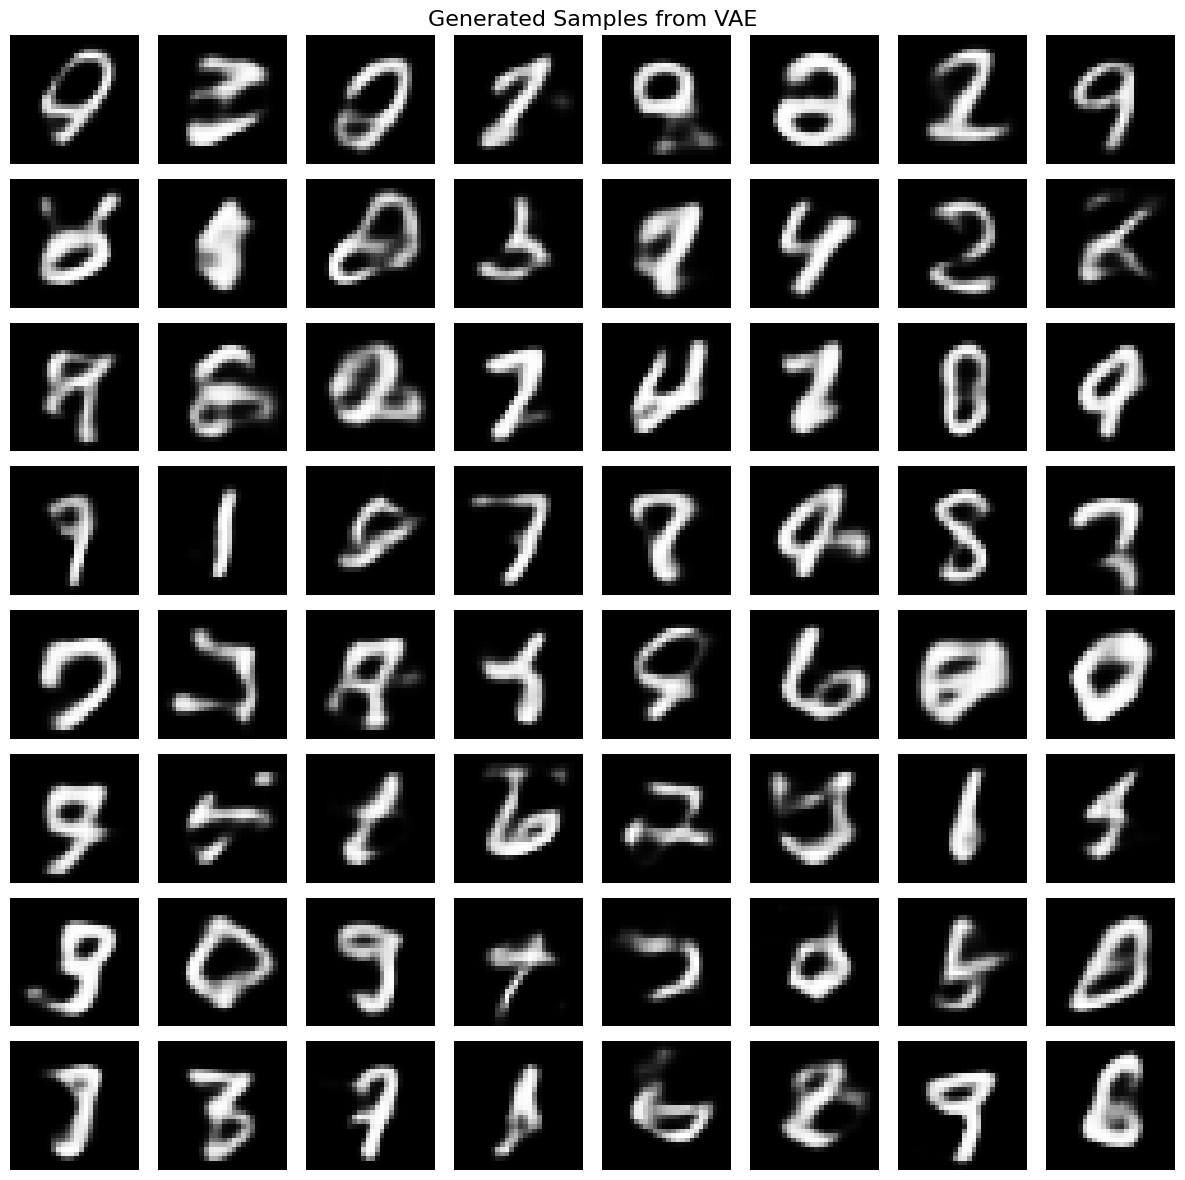

In [6]:
from sklearn.manifold import TSNE
# Generate new samples from the VAE
print("Generating new samples from VAE...")
vae.eval()
with torch.no_grad():
    # Sample from standard normal distribution
    z = torch.randn(64, vae.latent_dim).to(device)
    generated_images = vae.decode(z)

    # Plot generated samples
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            axes[i, j].imshow(generated_images[idx].cpu().squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.suptitle('Generated Samples from VAE', fontsize=16)
    plt.tight_layout()
    plt.show()



Visualizing VAE latent space...


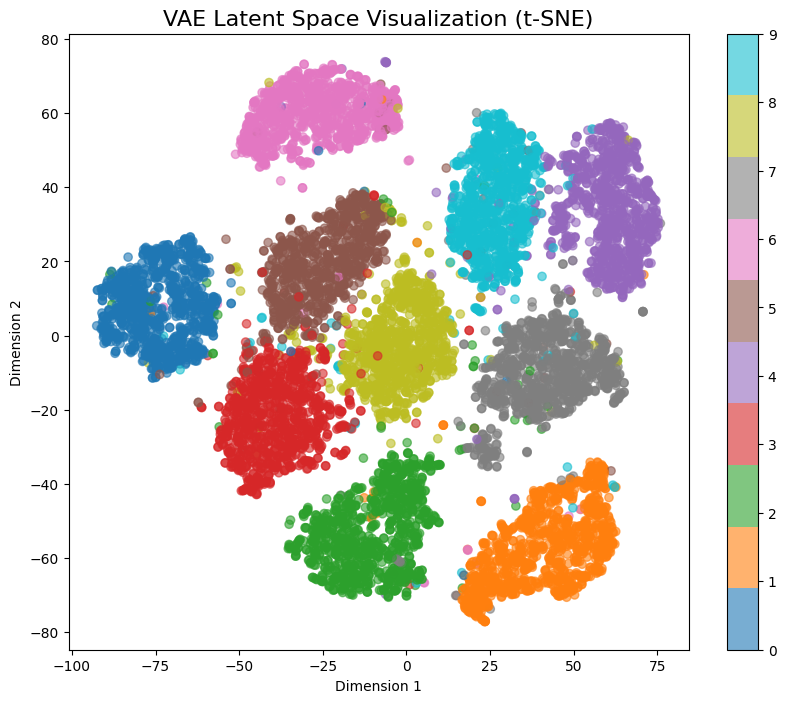

In [7]:
# Visualize VAE latent space with t-SNE
print("Visualizing VAE latent space...")
vae.eval()
latents_vae = []
labels_vae = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        mu, logvar = vae.encode(images)
        # Use mean for visualization
        latents_vae.append(mu.cpu())
        labels_vae.append(labels.cpu())

latents_vae = torch.cat(latents_vae, dim=0).numpy()
labels_vae = torch.cat(labels_vae, dim=0).numpy()

# Apply t-SNE
tsne_vae = TSNE(n_components=2, random_state=42)
latents_vae_2d = tsne_vae.fit_transform(latents_vae)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_vae_2d[:, 0], latents_vae_2d[:, 1], c=labels_vae, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10))
plt.title('VAE Latent Space Visualization (t-SNE)', fontsize=16)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()



Latent space interpolation...
Interpolating between digit 1 and digit 5


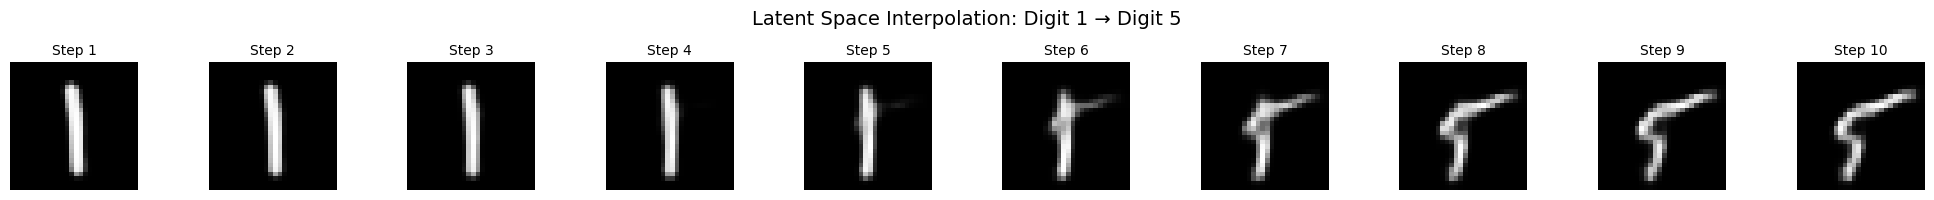

In [8]:
import random
# Compare latent space interpolation
print("Latent space interpolation...")
vae.eval()
with torch.no_grad():
    # Get random batch of test images
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)

    # Randomly select two different digits
    available_indices = list(range(len(test_labels)))
    idx1 = random.choice(available_indices)

    # Find a different digit
    different_digits = [i for i in available_indices if test_labels[i] != test_labels[idx1]]
    if different_digits:
        idx2 = random.choice(different_digits)
    else:
        # Fallback if somehow all digits are the same (very unlikely)
        idx2 = (idx1 + 1) % len(test_labels)

    print(f"Interpolating between digit {test_labels[idx1].item()} and digit {test_labels[idx2].item()}")

    # Encode the two images
    mu1, _ = vae.encode(test_images[idx1:idx1+1])
    mu2, _ = vae.encode(test_images[idx2:idx2+1])

    # Interpolate between the two latent vectors
    n_steps = 10
    interpolated_images = []

    for i in range(n_steps):
        alpha = i / (n_steps - 1)
        z_interp = (1 - alpha) * mu1 + alpha * mu2
        img_interp = vae.decode(z_interp)
        interpolated_images.append(img_interp)

    # Plot interpolation
    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i in range(n_steps):
        axes[i].imshow(interpolated_images[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Step {i+1}', fontsize=10)

    plt.suptitle(f'Latent Space Interpolation: Digit {test_labels[idx1]} → Digit {test_labels[idx2]}', fontsize=14)
    plt.tight_layout()
    plt.show()

Creating 2D manifold of digits...
Using latent dimensions 18 and 0 for manifold


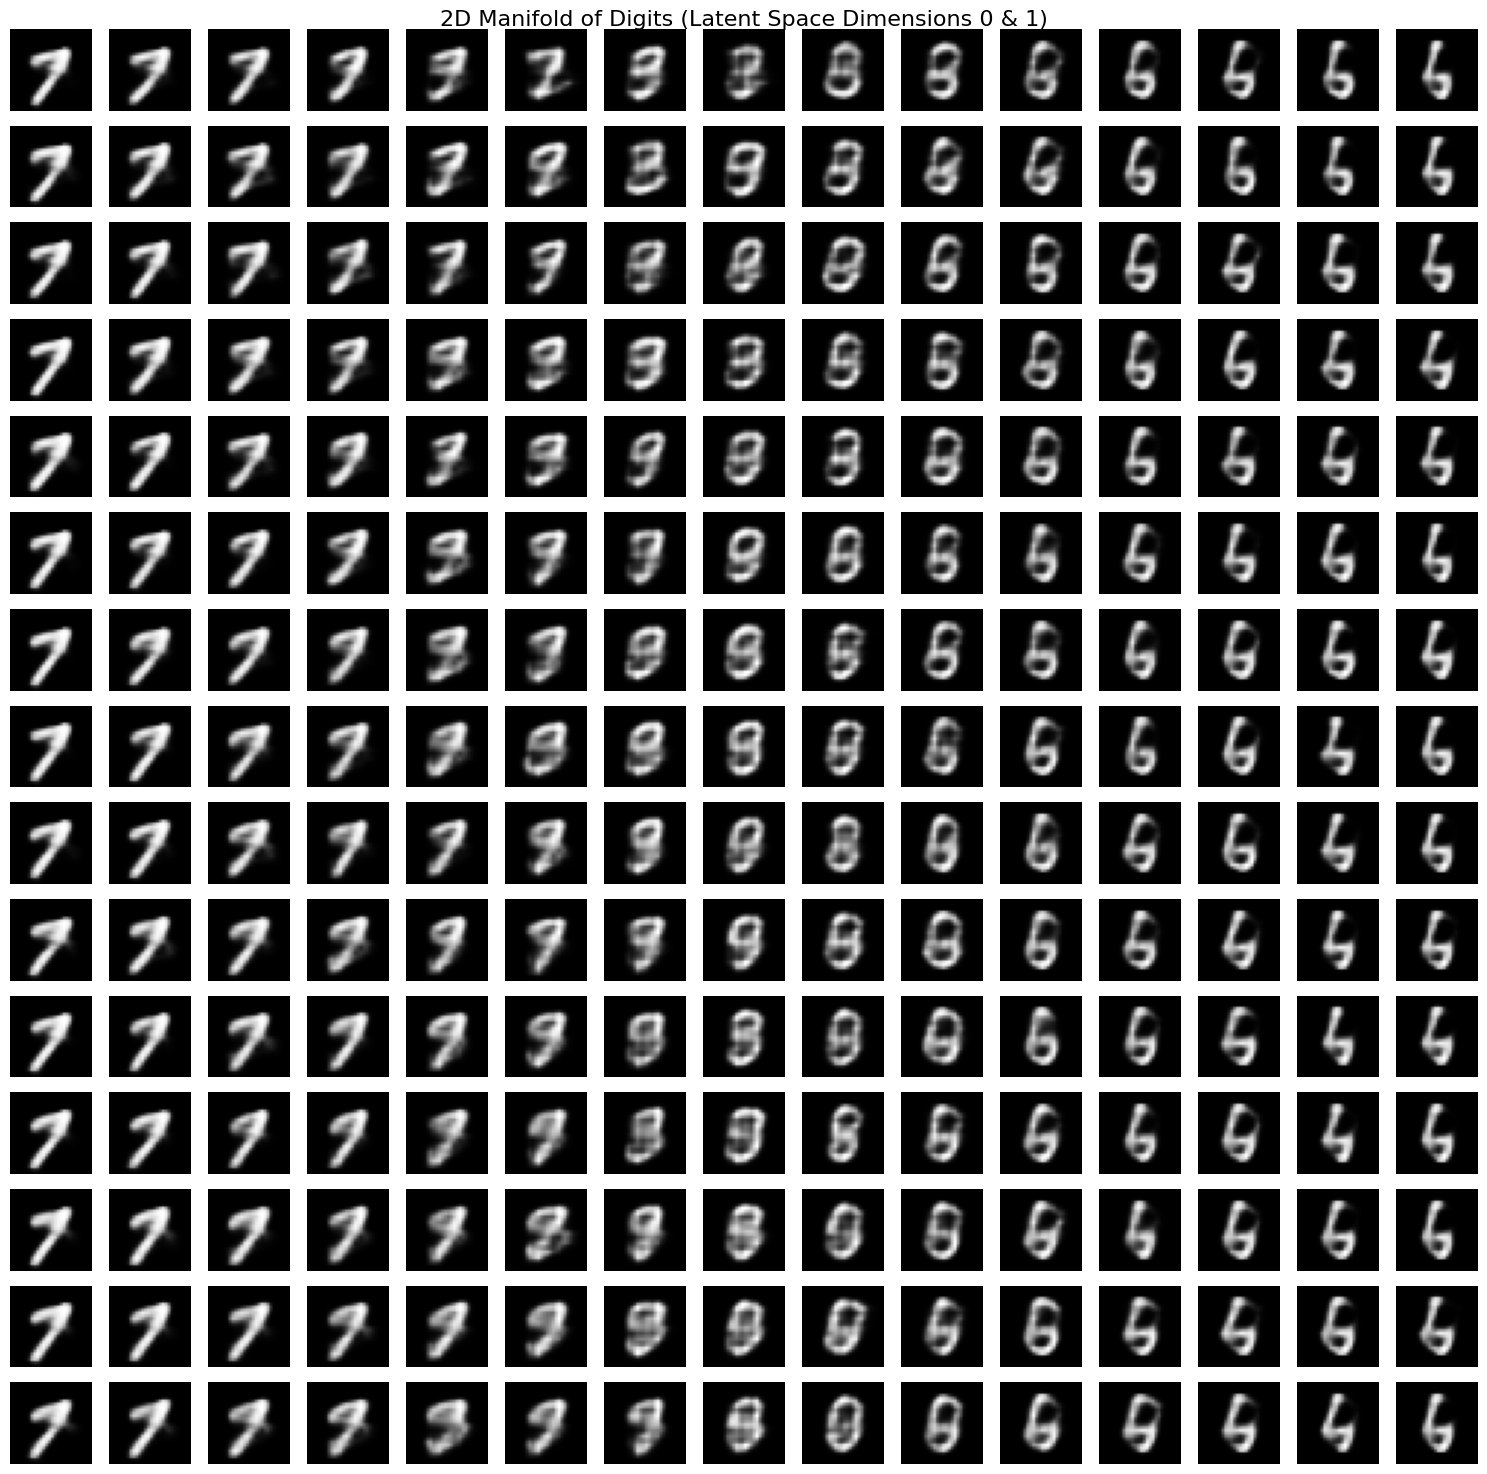

In [9]:
# Create a 2D manifold visualization of digits
print("Creating 2D manifold of digits...")

def plot_digit_manifold(vae, n_grid=15, figsize=(15, 15)):
    """
    Plot a 2D manifold of digits by sampling from a grid in latent space
    """
    vae.eval()

    # Create a grid of points in 2D latent space
    # We'll use the first 2 dimensions of the latent space
    grid_x = np.linspace(-3, 3, n_grid)
    grid_y = np.linspace(-3, 3, n_grid)

    fig, axes = plt.subplots(n_grid, n_grid, figsize=figsize)

    # Randomly select which 2 dimensions to use for the manifold
    dim1 = np.random.randint(0, vae.latent_dim)
    dim2 = np.random.randint(0, vae.latent_dim)
    while dim2 == dim1:
        dim2 = np.random.randint(0, vae.latent_dim)

    print(f"Using latent dimensions {dim1} and {dim2} for manifold")

    with torch.no_grad():
        for i, y in enumerate(grid_y):
            for j, x in enumerate(grid_x):
                # Create latent vector with small random noise in other dimensions
                z = torch.randn(1, vae.latent_dim).to(device) * 0.1  # Small noise
                z[0, dim1] = x
                z[0, dim2] = y

                # Decode the latent vector
                decoded_img = vae.decode(z)

                # Plot the decoded image
                axes[i, j].imshow(decoded_img.cpu().squeeze(), cmap='gray')
                axes[i, j].axis('off')

    plt.suptitle('2D Manifold of Digits (Latent Space Dimensions 0 & 1)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Import numpy if not already imported
import numpy as np

# Create the manifold visualization
plot_digit_manifold(vae, n_grid=15)

Creating detailed manifold visualization...
Detailed manifold region: X=[-4.24, 2.75], Y=[-2.74, 4.25]
Using latent dimensions 13 and 6 for detailed manifold


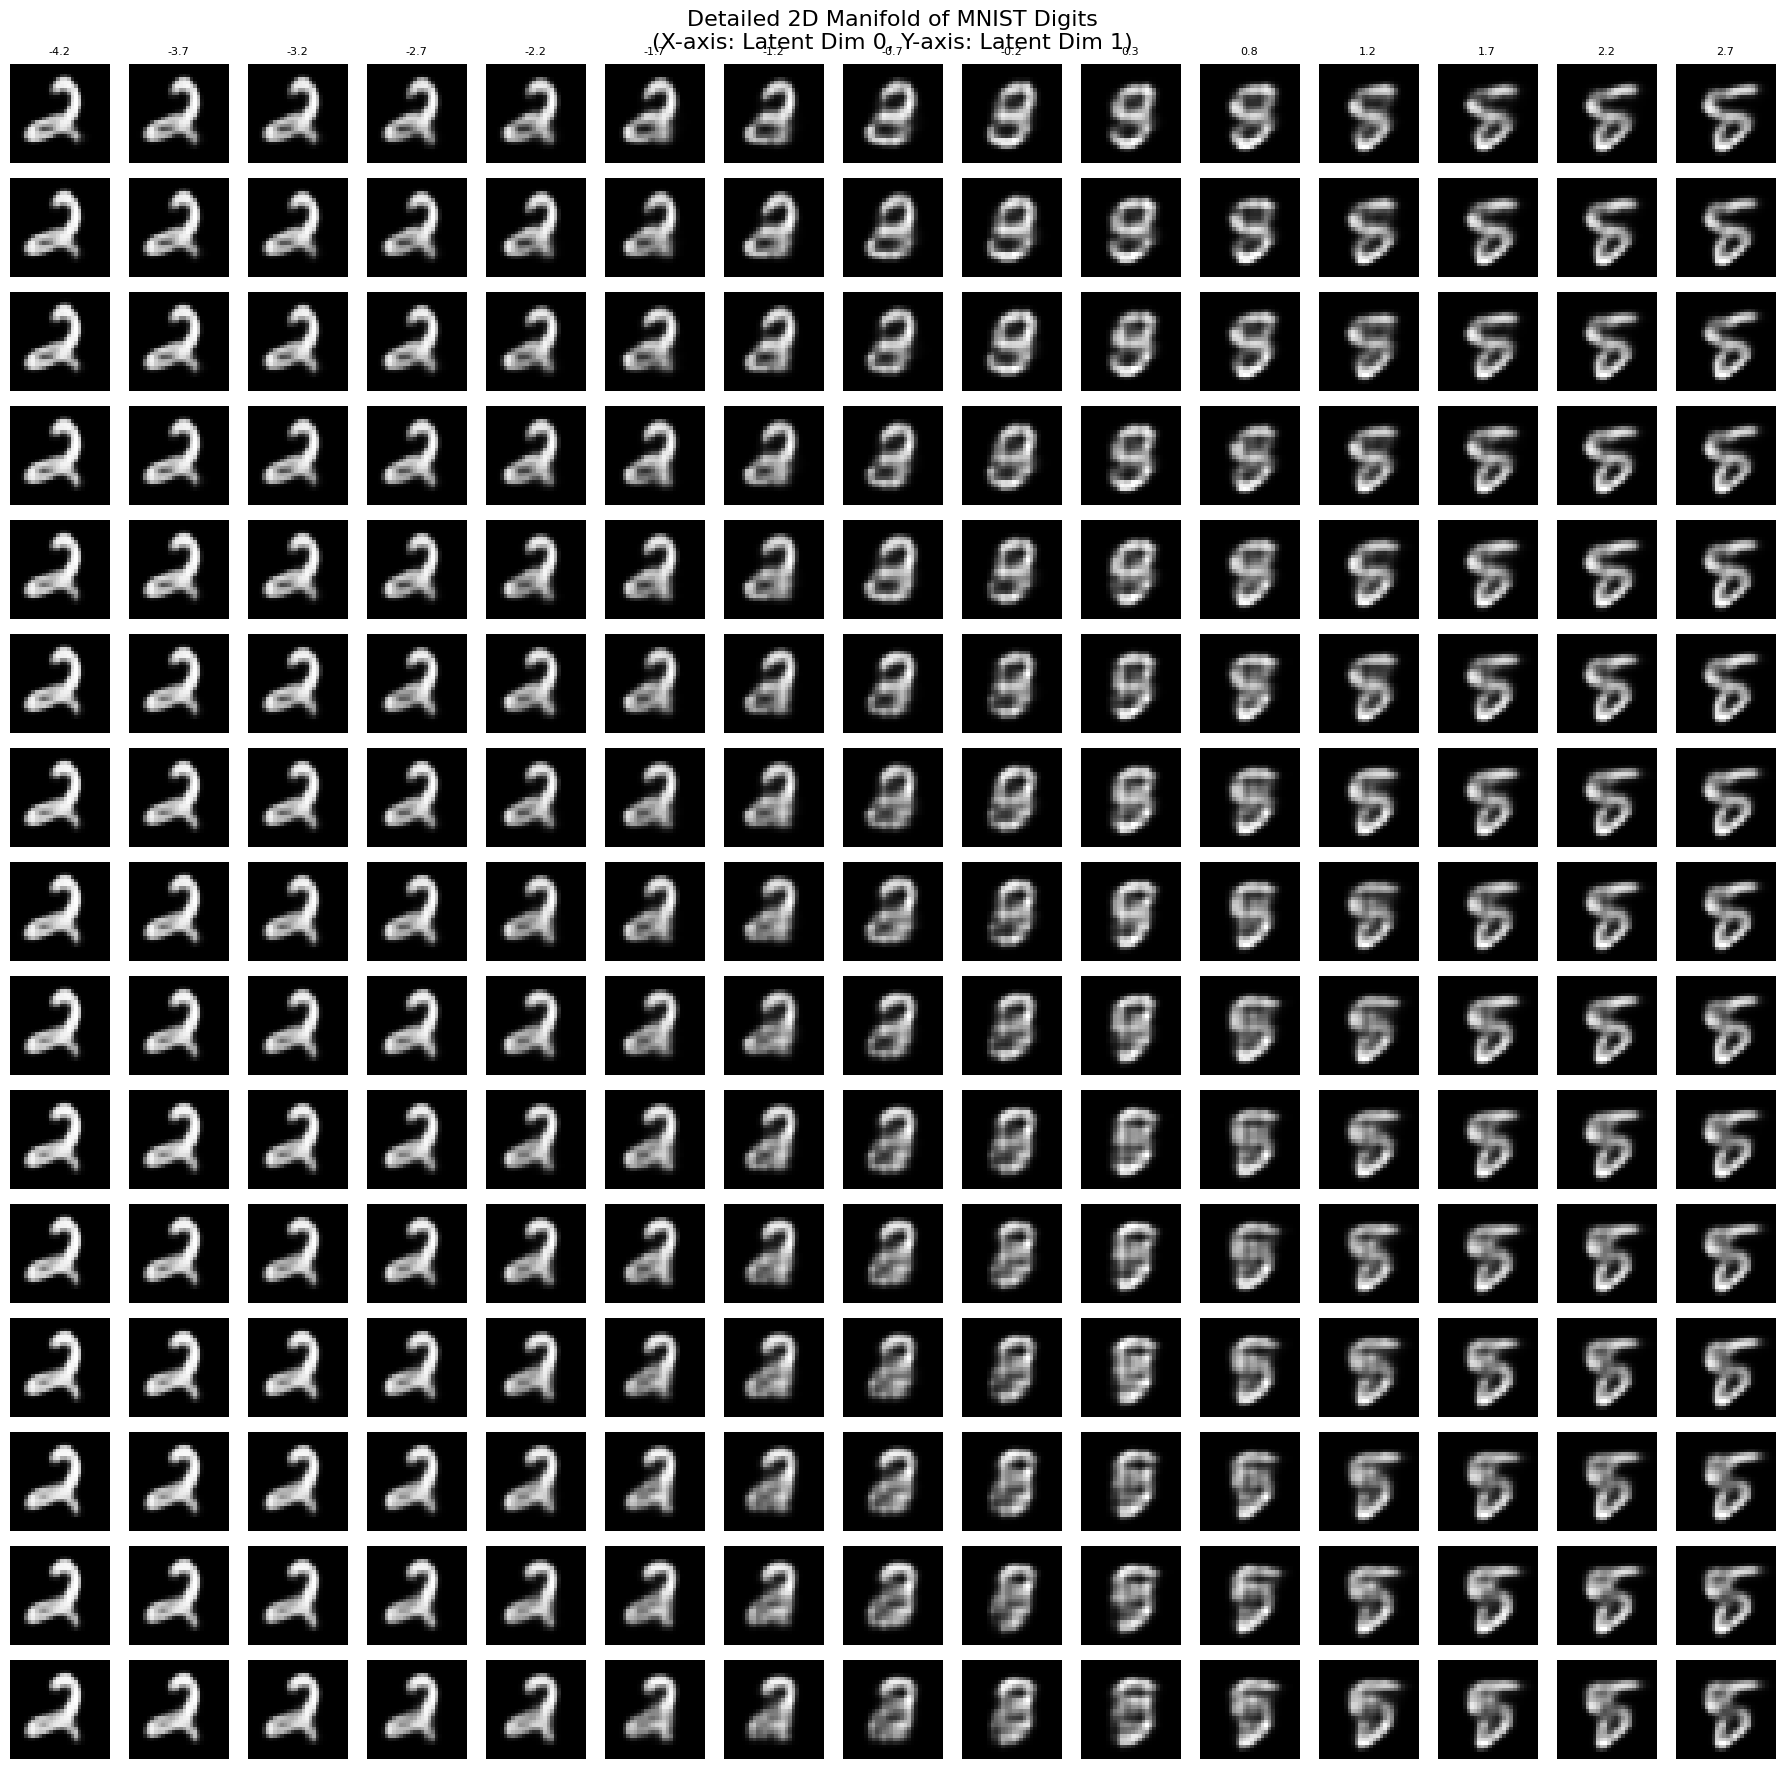

Creating circular manifold walk...
Circular walk: radius=2.99, center=(-0.29, 0.51)
Using latent dimensions 31 and 16 for circular walk


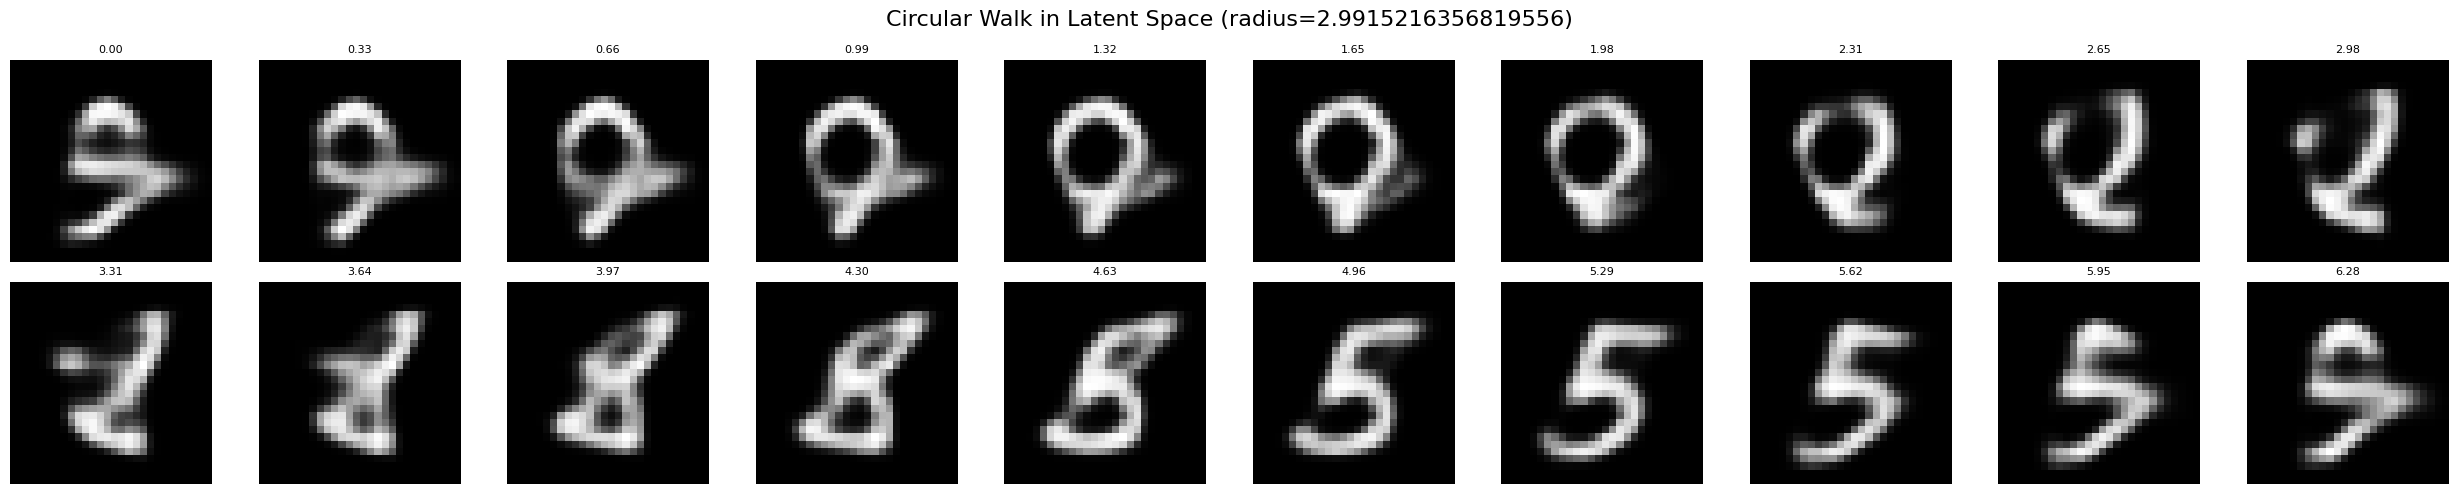

In [10]:
# Create a more detailed manifold with coordinate labels
def plot_detailed_manifold(vae, n_grid=20, figsize=(20, 20), range_val=None):
    """
    Create a detailed manifold plot with coordinate labels
    """
    vae.eval()

    # Create a finer grid with random ranges if not specified
    if range_val is None:
        range_val = np.random.uniform(1.8, 3.5)
    center_x = np.random.uniform(-0.8, 0.8)
    center_y = np.random.uniform(-0.8, 0.8)

    print(f"Detailed manifold region: X=[{center_x-range_val:.2f}, {center_x+range_val:.2f}], Y=[{center_y-range_val:.2f}, {center_y+range_val:.2f}]")

    grid_x = np.linspace(center_x - range_val, center_x + range_val, n_grid)
    grid_y = np.linspace(center_y - range_val, center_y + range_val, n_grid)

    fig, axes = plt.subplots(n_grid, n_grid, figsize=figsize)

    # Randomly select which 2 dimensions to use for the detailed manifold
    dim1 = np.random.randint(0, vae.latent_dim)
    dim2 = np.random.randint(0, vae.latent_dim)
    while dim2 == dim1:
        dim2 = np.random.randint(0, vae.latent_dim)

    print(f"Using latent dimensions {dim1} and {dim2} for detailed manifold")

    with torch.no_grad():
        for i, y in enumerate(grid_y):
            for j, x in enumerate(grid_x):
                # Create latent vector with small random noise in other dimensions
                z = torch.randn(1, vae.latent_dim).to(device) * 0.05  # Very small noise
                z[0, dim1] = x
                z[0, dim2] = y

                # Decode
                decoded_img = vae.decode(z)

                # Plot
                axes[i, j].imshow(decoded_img.cpu().squeeze(), cmap='gray')
                axes[i, j].axis('off')

                # Add coordinate labels for border cells
                if i == 0:  # Top row
                    axes[i, j].set_title(f'{x:.1f}', fontsize=8)
                if j == 0:  # Left column
                    axes[i, j].set_ylabel(f'{y:.1f}', fontsize=8, rotation=0, ha='right')

    plt.suptitle('Detailed 2D Manifold of MNIST Digits\n(X-axis: Latent Dim 0, Y-axis: Latent Dim 1)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Create detailed manifold
print("Creating detailed manifold visualization...")
plot_detailed_manifold(vae, n_grid=15, figsize=(18, 18))

# Also create a circular sampling manifold
def plot_circular_manifold(vae, n_samples=100, radius=None):
    """
    Sample points in a circle in 2D latent space to see transitions
    """
    vae.eval()

    # Randomize radius and center if not specified
    if radius is None:
        radius = np.random.uniform(1.5, 3.0)
    center_x = np.random.uniform(-1.0, 1.0)
    center_y = np.random.uniform(-1.0, 1.0)

    print(f"Circular walk: radius={radius:.2f}, center=({center_x:.2f}, {center_y:.2f})")

    angles = np.linspace(0, 2*np.pi, n_samples)

    fig, axes = plt.subplots(2, n_samples//2, figsize=(25, 5))
    axes = axes.flatten()

    # Randomly select which 2 dimensions to use for the circular walk
    dim1 = np.random.randint(0, vae.latent_dim)
    dim2 = np.random.randint(0, vae.latent_dim)
    while dim2 == dim1:
        dim2 = np.random.randint(0, vae.latent_dim)

    print(f"Using latent dimensions {dim1} and {dim2} for circular walk")

    with torch.no_grad():
        for i, angle in enumerate(angles):
            # Point on circle in latent space
            x = center_x + radius * np.cos(angle)
            y = center_y + radius * np.sin(angle)

            # Create latent vector with small random noise in other dimensions
            z = torch.randn(1, vae.latent_dim).to(device) * 0.05
            z[0, dim1] = x
            z[0, dim2] = y

            decoded_img = vae.decode(z)

            axes[i].imshow(decoded_img.cpu().squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'{angle:.2f}', fontsize=8)

    plt.suptitle(f'Circular Walk in Latent Space (radius={radius})', fontsize=16)
    plt.tight_layout()
    plt.show()

print("Creating circular manifold walk...")
plot_circular_manifold(vae, n_samples=20)  # radius will be random